# Convolutional Neural Network: Cats and Dogs classifier

12500 cat pictures and 12500 dog pictures

(pip install pillow image)

* Kein Data Cleaning nötig, da Bilder schon sauber und korrekt sind

In [44]:
# All imports here...

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image

# Helper libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os import makedirs
from PIL import Image
from numpy import asarray
from numpy import save
from numpy import load
from shutil import copyfile
from random import seed
from random import random

print(tf.__version__)

sys.modules['Image'] = Image 

2.1.0


<b>Plot some dogs from the dataset</b>

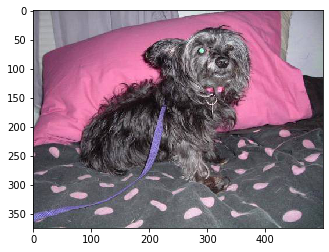

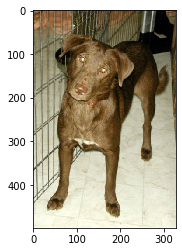

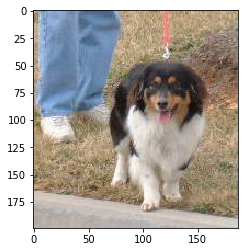

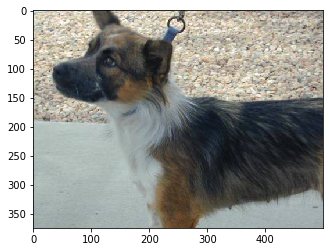

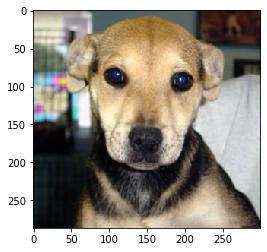

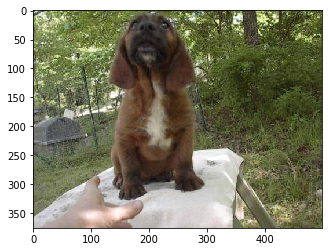

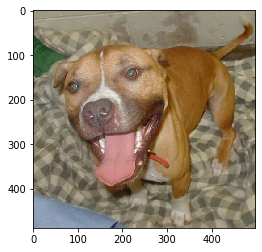

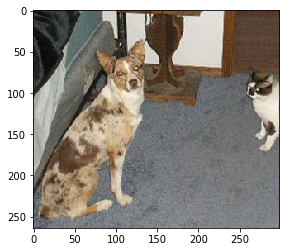

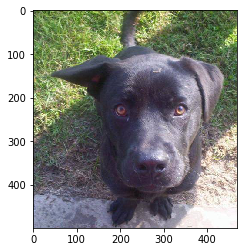

In [2]:
folder = 'dataset/cats_dogs/train/'

# plot first few images
for i in range(9):
    filename = folder + 'dog.' + str(i) + '.jpg'
    image = Image.open(filename)
    imgplot = plt.imshow(image)
    plt.show()

<b>Pre-Process Photo Sizes</b>

In [3]:
photos, labels = list(), list()

# enumerate files in the directory
for file in listdir(folder):
    # determine class
    output = 0.0
    if file.startswith('cat'):
        output = 1.0
    # load image
    photo = load_img(folder + file, target_size=(200, 200))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    photos.append(photo)
    labels.append(output)

# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)

# save the reshaped photos
save('dogs_vs_cats_photos.npy', photos)
save('dogs_vs_cats_labels.npy', labels)

(25000, 200, 200, 3) (25000,)


In [4]:
# load and confirm the shape
photos = load('dogs_vs_cats_photos.npy')
labels = load('dogs_vs_cats_labels.npy')
print(photos.shape, labels.shape)

(25000, 200, 200, 3) (25000,)


<b>Pre-Process Photos into Standard Directories</b>

This API prefers data to be divided into separate train/ and test/ directories, and under each directory to have a subdirectory for each class, e.g. a train/dog/ and a train/cat/ subdirectories and the same for test. Images are then organized under the subdirectories.

<pre>
<b>dataset_dogs_vs_cats</b>
|__ <b>test</b>
    |______ <b>cats</b>
    |______ <b>dogs</b>
|__ <b>train</b>
    |______ <b>cats</b>
    |______ <b>dogs</b>
</pre>

In [5]:
# create directories
dataset_home = 'dataset/dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

Next, we can enumerate all image files in the dataset and copy them into the dogs/ or cats/ subdirectory based on their filename.

Additionally, we can randomly decide to hold back 25% of the images into the test dataset. This is done consistently by fixing the seed for the pseudorandom number generator so that we get the same split of data each time the code is run.

After running the example, you will now have a new dataset_dogs_vs_cats/ directory with a train/ and val/ subfolders and further dogs/ can cats/ subdirectories, exactly as designed.

In [6]:
# seed random number generator
seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.25

# copy training dataset images into subdirectories
src_directory = folder
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)

<b>Let's look at how many cats and dogs images are in the training and test directory:</b>

In [7]:
train_dir = 'dataset/dataset_dogs_vs_cats/train'
train_cats_dir = 'dataset/dataset_dogs_vs_cats/train/cats'
train_dogs_dir = 'dataset/dataset_dogs_vs_cats/train/dogs'
test_dir = 'dataset/dataset_dogs_vs_cats/test'
test_cats_dir = 'dataset/dataset_dogs_vs_cats/test/cats'
test_dogs_dir = 'dataset/dataset_dogs_vs_cats/test/dogs'

num_cats_tr = len(listdir(train_cats_dir))
num_dogs_tr = len(listdir(train_dogs_dir))

num_cats_test = len(listdir(test_cats_dir))
num_dogs_test = len(listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_test = num_cats_test + num_dogs_test

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total test cat images:', num_cats_test)
print('total test dog images:', num_dogs_test)
print("--")
print("Total training images:", total_train)
print("Total test images:", total_test)

total training cat images: 9320
total training dog images: 9377
total test cat images: 3180
total test dog images: 3123
--
Total training images: 18697
Total test images: 6303


## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [8]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 200
IMG_WIDTH = 200

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


<b>Visualize training images</b>

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

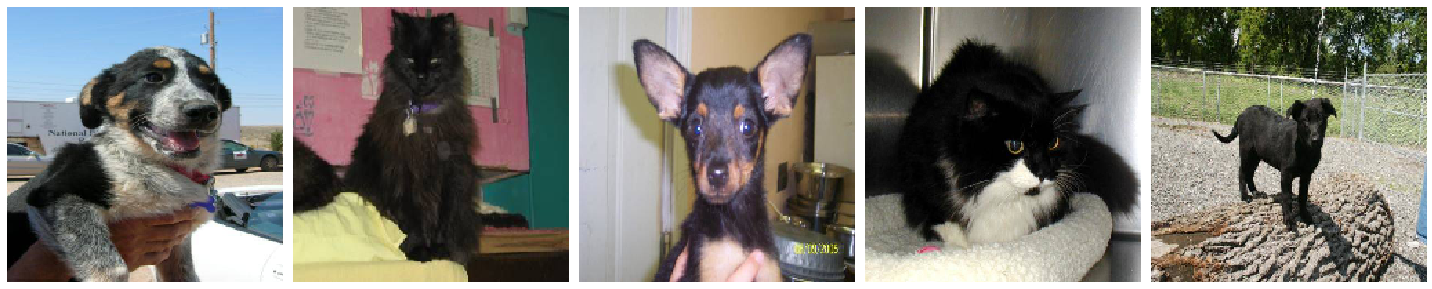

In [9]:
sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

## Building the CNN

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [10]:
# Initialize the CNN

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

# Compiling the CNN
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

# View all the layers of the network using the model's `summary` method:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0

<b>Train the model</b>

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [11]:
#https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps

#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#validation_steps = TotalvalidationSamples / ValidationBatchSize

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=20,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=20
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 20 steps
Epoch 1/15
20/20 [==============================] - 69s 3s/step - loss: 1.1988 - accuracy: 0.5000 - val_loss: 0.6883 - val_accuracy: 0.5070
Epoch 2/15
20/20 [==============================] - 68s 3s/step - loss: 0.6810 - accuracy: 0.5160 - val_loss: 0.6682 - val_accuracy: 0.5461
Epoch 3/15
20/20 [==============================] - 64s 3s/step - loss: 0.6478 - accuracy: 0.5895 - val_loss: 0.6479 - val_accuracy: 0.5625
Epoch 4/15
20/20 [==============================] - 65s 3s/step - loss: 0.6417 - accuracy: 0.5941 - val_loss: 0.6169 - val_accuracy: 0.6156
Epoch 5/15
20/20 [==============================] - 65s 3s/step - loss: 0.6001 - accuracy: 0.6348 - val_loss: 0.5735 - val_accuracy: 0.6770
Epoch 6/15
20/20 [==============================] - 65s 3s/step - loss: 0.5794 - accuracy: 0.6660 - val_loss: 0.5568 - val_accuracy:

<b>Visualize and evaluate training results</b>

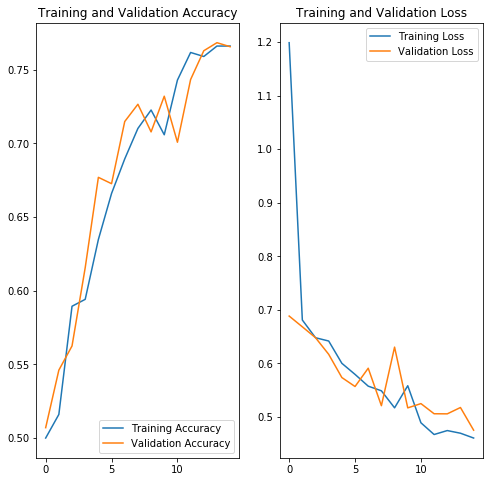


# Evaluate
  ...
    to  
  ['...']
50/50 [==============================] - 585s 12s/step - loss: 0.4772 - accuracy: 0.7715
[0.477199530005455, 0.77153736]


In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('\n# Evaluate')
result = model.evaluate(test_data_gen)
print(result)

=> After 15 epochs the model has scored 78,45% accuracy on training set and 76,33% accuracy on the validation set. This is a clear indication that our model has not overfitted. Our model will perform really good in the training set and it will also same for the unseen data.

=> To fix overfitting: add regularization to avoid over-complexing the model or add more data to the training set to make the model more generalized for unseen data (25k data should be okay, so skip this..., e.g. horizontal flip of the image, rotation etc.)

=> If we have < 2500 images, we should do this...

# TBD (Optimization, Verbesserungen, Dropout Reg., kernel-size/filter höher, mehr epochs, mehr dense layer etc.)

# Make predictions

Note: the subdirectories of images, one for each class, are loaded by the flow_from_directory() function in alphabetical order and assigned an integer for each class. The subdirectory “cat” comes before “dog“, therefore the class labels are assigned the integers: cat=0, dog=1. This can be changed via the “classes” argument in calling flow_from_directory() when training the model.

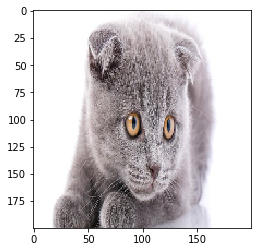

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>

In [51]:
#sample = 'dataset/dataset_dogs_vs_cats/test/dogs/dog.9999.jpg'
#sample = 'dataset/dataset_dogs_vs_cats/test/cats/cat.997.jpg'
sample_folder = 'dataset/samples/'
filename = "katze-1.jpg"

sample = sample_folder + filename

# load the image
test_img = image.load_img(sample, target_size=(200, 200))

# Show sample
plt.imshow(test_img)
plt.show()

# convert to array
#test_img = image.img_to_array(test_img)

# resize
#test_img = np.array(test_img).astype('float32')/255

#test_img = np.expand_dims(test_img, axis=0)

# reshape into a single sample with 3 channels
#test_img = test_img.reshape(1, 200, 200, 3)

# Predict
result = model.predict(test_img)

print(result)

train_data_gen.class_indices


# hund 1: [370.03998]
# hund 2: [18.105604]
# katze 1: [-463.25168]
# katze 2: [1.3439422]

# Autos sollte er nicht erkennen können...
# auto 1: [287.67352]
# auto 2: [556.49817]

# Conclusion

Bla bla bla

Herausforderungen:
* Gescheite datasets finden...
* https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model

# Next: CNN to predict persons/humans, cars, dogs and cats